# CS224 - Spring 2025 - HW1 - Joy-o-Meter

Submit **PDF** of completed IPython notebook on Canvas

**Due**: February 2, 2025 @ 11:59pm PDT

**Maximum points**: 15 (each HW is %15 of total grade)

<div style="margin-bottom: 15px; padding: 15px; color: #31708f; background-color: #d9edf7; border: 1px solid #bce8f1; border-radius: 5px;">
    
<b><font size=+2>Enter your information below:</font></b></br></br>

  <b>(full) Name</b>: Ranjitha Narasimhamurthy
  
  </br></br>
    
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>
</div>

# Overview
In this assignment you will implement a simple linear neural network that reads in text and uses pretrained embeddings to predict the **happiness intensity** of the text.
You'll fit the network weights using the analytic expression we discussed in class.

For this assignment we will use the functionality of PyTorch, HuggingFace "transformers" library for getting pretrained models, "pandas" for data loading, matplotlib for visualization. Before you start, make sure you have installed all those packages in your local Jupyter instance. Or use Google Colab (which has everything you need pre-installed).

Read **all** cells carefully and answer **all** parts (both text and missing code). You will complete all the code marked `TODO` and print desired results.

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## **Getting and processing data [2 points]**
You can download the two data files here:

https://elearn.ucr.edu/files/17302828/download?download_frd=1

https://elearn.ucr.edu/files/17302824/download?download_frd=1

You'll have to make them available locally or upload them to your colab instance.

In [ ]:
# Load dataset and visualize
train_file = 'EI-reg-En-joy-train.txt'
val_file = '2018-EI-reg-En-joy-dev.txt'
df_train = pd.read_csv(train_file, sep='\t')
df_val = pd.read_csv(val_file, sep='\t')

tweets_train = df_train['Tweet'].tolist()  # Create a list of tweets
tweets_val = df_val['Tweet'].tolist()

# Create a list of intensity scores
y_train = torch.tensor(df_train['Intensity Score'], dtype=torch.float32)  # match to dtype of embedding
y_val = torch.tensor(df_val['Intensity Score'], dtype=torch.float32)

print('Score - Tweet')
for i in range(5):
    print('{:0.2f} - {}'.format(y_train[i], tweets_train[i]))

Score - Tweet
0.14 - @david_garrett Quite saddened.....no US dates, no joyous anticipation of attending a DG concert (since 2014). Happy you are keeping busy.
0.79 - 2 days until #GoPackGo and 23 days until #GoGipeGo..... I'm so excited! 
0.27 - Positive #psychology research shows salespeople who score in the top 10% for #optimism have 88% &gt; sales than those in top 10% for pessimism.
0.48 - As the birds chirp and the cows moo we need to listen to the sound of nature to ensure that all is well.
0.94 - Howling with laughter at “WELL DONE BEZZA!” #bakeoff #GBBO


In [ ]:
# TODO [1 point]: load a pretrained model and write a function that embeds sentences into vector space
# Use the approach shown in Jan. 17 class (or improve on it)

model_name="bert-base-uncased"  # Many possibilities on huggingface.com
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)


def embed_sentence(model, tokenizer, sentence):
    """Function to embed a sentence as a vector using a pre-trained model."""
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True,max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling over tokens
    return embeddings.squeeze(0)  # Ensure shape is (768,)

In [ ]:
# TODO [1 point]: Use embed_sentence to turn text into a matrix of embeddings.
# Create a pytorch matrix where each row corresponds to a tweet,
# and the number of columns/features is the size of the embedding
# (Obviously one for train and one for validation)
# For me, on the CPU of my laptop, it took about a minute or two to do the processing

# Convert all tweets into embeddings
X_train = torch.stack([embed_sentence(bert_model, tokenizer, tweet) for tweet in tweets_train]) # Changed train_texts to tweets_train
X_val = torch.stack([embed_sentence(bert_model, tokenizer, tweet) for tweet in tweets_val]) # Changed val_texts to tweets_val

# Print the shape of resulting tensors
print(X_train.shape, X_val.shape)  # Expected output: (num_samples, 768)


torch.Size([1616, 768]) torch.Size([290, 768])


## Define the model [5 points]
The model implements a linear model $$\hat{y}(x) = \mathbf w \cdot \mathbf x + b.$$ The "fit" method should use the analytic formula discussed in class to minimize the loss, $$L(\mathbf w, b) = \sum_{i=1}^N (y_i -  \hat y(\mathbf x_i))^2 + \gamma (\sum_{j=1}^d w_i^2 + b^2)$$
Our L2 regularizer is applied to all the parameters for simplicity. But note that it is common in neural nets to only apply L2 regularization to the weights and not the biases.

In [ ]:
class MyLinearNet(torch.nn.Module):
    def __init__(self, input_embedding_size):
        super().__init__()  # init superclass - enables many pytorch model capabilities
        self.d = input_embedding_size  # Often convenient to store this (not a "Parameter" though as we don't train it)
        # TODO [1 point]: define weights and bias with "Parameters"
        self.w = torch.nn.Parameter(torch.randn(self.d, 1))  # Weight as a column vector
        self.b = torch.nn.Parameter(torch.randn(1))          # Bias as a scalar


    def forward(self, x):
        """Implement a linear model"""
        # TODO [1 point]: implement linear model, in terms of weights and biases
        return torch.matmul(x, self.w).squeeze() + self.b


    def fit(self, X, y, gamma=0.):
        """Given a data matrix, X, and a vector of labels for each row, y,
        analytically fit the parameters of the linear model.
        Use an L2 regularizer with strength 'gamma'."""
        # TODO [3 points]: Use linear regression formula to set weight and bias parameters

        # (a) First, construct the augmented data matrix as discussed in class
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)  # (N x (d+1))
        # (b) Next, use matrix multiplication and torch.linalg.inv to implement the analytic solution
        I = torch.eye(X_aug.shape[1])
        I[-1, -1] = 0  # Ensure bias term is NOT regularized
        w = torch.linalg.inv(X_aug.T @ X_aug + gamma * I) @ X_aug.T @ y

        # (c) Put the solution (which includes weights and biases) into parameter
        # Use "data" to update parameters without affecting computation graph
        # (Kind of a subtle point - no need to modify my code below)
        self.w.data = w[:-1].reshape(-1, 1)  # Reshape weights to (d,1)
        self.b.data = w[-1]  # Bias remains a scalar


## Results [8 points]

First look at training and validation loss

In [ ]:
def loss(model, X, y):
    # TODO [1 point]: implement the mean square error loss
    y_pred = model(X)  # Predict using the model
    return torch.mean((y - y_pred) ** 2)  # Compute MSE loss

d = X_train.shape[1]  # embedding dimension
model = MyLinearNet(d)

loss_train = loss(model, X_train, y_train)
loss_val = loss(model, X_val, y_val)
print("\nLoss on train and validation BEFORE fitting.\nTrain: {:0.3f}, Val: {:0.3f}".format(loss_train, loss_val))

model.fit(X_train, y_train, gamma=0.)

loss_train = loss(model, X_train, y_train)
loss_val = loss(model, X_val, y_val)
print("\nLoss on train and validation AFTER fitting WITHOUT regularization.\nTrain: {:0.3f}, Val: {:0.3f}".format(loss_train, loss_val))

model.fit(X_train, y_train, gamma=0.1)

loss_train = loss(model, X_train, y_train)
loss_val = loss(model, X_val, y_val)
# TODO [5 points]: Show that Train loss is reduced below 0.02
# and Validation loss is reduced below 0.05, at least
# Adjust the regularizer strength to improve validation loss.
print("\nLoss on train and validation AFTER fitting WITH regularization.\nTrain: {:0.3f}, Val: {:0.3f}".format(loss_train, loss_val))



Loss on train and validation BEFORE fitting.
Train: 41.848, Val: 42.428

Loss on train and validation AFTER fitting WITHOUT regularization.
Train: 0.685, Val: 1.004

Loss on train and validation AFTER fitting WITH regularization.
Train: 0.009, Val: 0.042


Visualize correlation between predicted and true labels, y

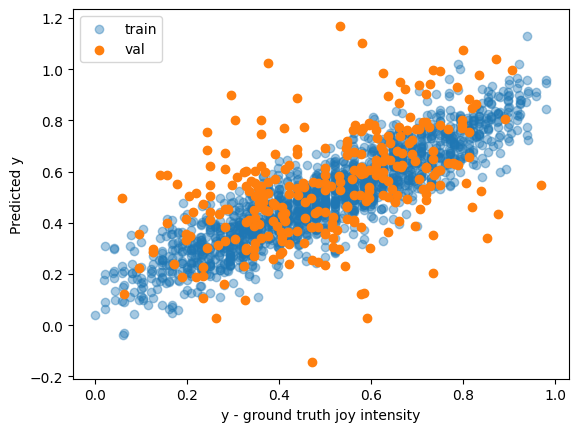

In [ ]:
# Use only the regularized model for the results below.
# Create a scatter plot of the actual vs. predicted values of `y` using this function.
def plot(y_train, y_hat_train, y_val, y_hat_val):
    fig, ax = plt.subplots(1)
    ax.scatter(y_train, y_hat_train, alpha=0.4, label='train')
    ax.scatter(y_val, y_hat_val, label='val')
    ax.set_xlabel('y - ground truth joy intensity')
    ax.set_ylabel('Predicted y')
    ax.legend()


# TODO [1 point] show y_hat versus y on train and val data
# Should be no need to modify code, you get 1 point for getting
# something that looks correct.
with torch.no_grad():  # remember to turn off auto gradient tracking
    y_hat_train = model(X_train)
    y_hat_val = model(X_val)

plot(y_train, y_hat_train, y_val, y_hat_val)

In [ ]:
# TODO [1 point]  Put in a sample sentence of your own construction and output the "joy meter" for a happy and sad sentence
happy = "I am so thrilled to complete this homework!"
sad = "It’s hard to find hope when everything keeps falling apart."

# Generate embeddings using BERT
happy_embed = embed_sentence(bert_model, tokenizer, happy).squeeze(0)  # Ensure shape (768,)
sad_embed = embed_sentence(bert_model, tokenizer, sad).squeeze(0)  # Ensure shape (768,)

# Predict joy scores using the trained linear model
happy_score = model(happy_embed.unsqueeze(0))  # Ensure correct shape for MyLinearNet
sad_score = model(sad_embed.unsqueeze(0))

# Apply sigmoid to normalize values between [0,1]
happy_score = torch.sigmoid(happy_score)
sad_score = torch.sigmoid(sad_score)

# Print final joy scores
print(f"Joy-O-meter Score (Happy): {happy_score.item():.2f}")
print(f"Joy-O-meter Score (Sad): {sad_score.item():.2f}")


Joy-O-meter Score (Happy): 0.75
Joy-O-meter Score (Sad): 0.47


### Exporting the Notebook to PDF
To generate a nice looking PDF of your completed notebook, either use "Print" as PDF from Google colab (using Chrome), or if you are running locally, run the following command in the last cell:
```python
!jupyter nbconvert --to pdf --output=yourname_submission.pdf hw1.ipynb
```

## Extra credit

There are some nice opportunities for extra credit, though I will be fairly stingy with the points, so you should only try it if you're interested in learning more.
Some examples of things you could try for 1 extra point.
- Compare multiple embedding methods. For instance, I'd look at a contrastive method like
princeton-nlp/unsup-simcse-bert-base-uncased or sentence-transformers/all-mpnet-base-v2 and a CLIP variant (trained on text and images). I hypothesize the contrastive methods will be better than CLIP for this task (which is not a visual task). You could also try a GPT model embedding, but while they are great at generation the embeddings are typically not useful for other tasks.
- Work ahead and try putting in a multi-layer MLP and training with SGD. How much can you improve the validation loss?
- Compare different strategies for extracting BERT embeddings: instead of using the mean embedding like I showed in class, compare to the embedding from the first token (to make this work better, people sometimes prepend the sentence with a special [cls] token before tokenizing).